# Part 3 - NLP to extract Themes discussed 
1. Preliminary Cleaning
2. Build common Modeling Functions
3. Topic Modeling
    * LSA
    * Corex
4. Merge predictions with Main Dataframe
5. Making sense of the data


In [41]:
import numpy as np
import re
import string
import nltk
import sklearn
from nltk.tokenize import MWETokenizer 
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 50)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_pickle('initial_test_dataframe.pkl')


In [65]:
df.head()

,index,episode,season_number,episode_number,speaker,dialogue,writers,before_speaker,after_speaker,sentence_length,dial_clean
0,3,The One Where Monica Gets a New Roomate (The P...,1,1,Phoebe,"Wait, does he eat chalk?",Marta Kauffman & David Crane,NaN,Phoebe,6,wait does he eat chalk
1,4,The One Where Monica Gets a New Roomate (The P...,1,1,Phoebe,"Just, 'cause, I don't want her to go through\...",Marta Kauffman & David Crane,Phoebe,Monica,16,just cause i don t want her to go through\...
2,5,The One Where Monica Gets a New Roomate (The P...,1,1,Monica,"Okay, everybody relax. This is not even a\nda...",Marta Kauffman & David Crane,Phoebe,Chandler,21,okay everybody relax this is not even a\nda...
3,6,The One Where Monica Gets a New Roomate (The P...,1,1,Chandler,Sounds like a date to me.,Marta Kauffman & David Crane,Monica,Chandler,7,sounds like a date to me
4,7,The One Where Monica Gets a New Roomate (The P...,1,1,Chandler,"Alright, so I'm back in high school, I'm\nsta...",Marta Kauffman & David Crane,Chandler,Chandler,22,alright so i m back in high school i m\nsta...


In [4]:
test_df = df.copy()

==============================================================================================================

## 1. Preprocessing

#### A. Remove character names from the dialogue

In [14]:
characters = list(test_df['speaker'].unique())
def remove_name(sentence):
    sentence = re.sub('[%s]' % re.escape(string.punctuation), ' ', sentence)
    words = sentence.split(' ')
    sent_clean = ''
    for word in words:
        if word not in characters:
            sent_clean += word + ' '
    return sent_clean

In [15]:
test_df['dial_clean'] = test_df['dial_clean'].apply(lambda x: remove_name(x))


#### B. Definte the stop words

In [46]:
stop_word = stopwords.words('english')
# accepted_words = ['i','me','my','myself','we','our','you','he','him','his','she','her',
#  'they','them','what','which','who','whom','but','because','against','when','where','why','how',
#  'no','nor','not']
# final_stops = [x for x in stop_word if x not in accepted_words]
# print(final_stops)

## 2. Build the common functions

In [18]:
def vectorize(dataframe, column, vectorizer, stops, min_df = 0, max_df = 1.0, n_grams = (1, 1)):
    if vectorizer == "cv":
        vec = CountVectorizer(stop_words=stops, binary=True, min_df = min_df, max_df = max_df, ngram_range=n_grams)
    elif vectorizer == "tfidf":
        vec = TfidfVectorizer(stop_words=stops, binary=True, min_df = min_df, max_df = max_df, ngram_range=n_grams)

    
    doc_word = vec.fit_transform(dataframe[column])
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word

In [19]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

In [20]:

def corex(doc_word, feature_names, num_topics, anchors, anchor_strength):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, anchors=anchors, anchor_strength=anchor_strength)

    topics = model.get_topics(n_words=30)
    print("TC: ", model.tc)
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: \n'.format(n) + ', '.join(topic_words))

==============================================================================================================

# 3. Topic Analysis

### A. Using LSA to see if I can identify any topics that are discussed: 
- In the end, LSA did not do a very good job at this  

In [47]:
#Building the Episode Data Frame
episode_df = test_df.groupby(["season_number", 'episode_number','speaker'])
episode_df = episode_df["dial_clean"].agg(lambda column: " ".join(column)).reset_index()

episode_df.head(10)

,season_number,episode_number,speaker,dial_clean
0,1,1,Chandler,sounds like a date to me alright so i m ...
1,1,1,Joey,instead of never had that dream th...
2,1,1,Monica,okay everybody relax this is not even a\nda...
3,1,1,Phoebe,wait does he eat chalk just cause i d...
4,1,1,Rachel,oh god monica hi thank god i just went to\n...
5,1,1,Ross,hi i just feel like someone reached down...
6,1,2,Chandler,yeah i think for us kissing is pretty much ...
7,1,2,Joey,yeah right y serious are we ...
8,1,2,Monica,what you guys don t understand is for us \nk...
9,1,2,Phoebe,oh yeah then i ve already seen this o...


#### 1st Pass

In [48]:
#This is useless
doc_word1, feature_names1, id2word1= vectorize(episode_df, 'dial_clean', 'cv', stop_word)
lsa(doc_word1, feature_names1, 5)


Topic  0
oh, know, yeah, hey, well, okay, right, like, get, gonna, really, think, go, look, one, mean, see, got, uh, come

Topic  1
love, umm, married, thank, please, much, wait, great, hi, tell, ohh, god, talk, would, mean, honey, wanted, together, said, actually

Topic  2
ah, man, see, ya, thanks, time, life, guy, two, thing, tomorrow, woman, wanna, need, last, fine, got, thank, big, whole

Topic  3
got, monica, let, chandler, time, guys, joey, believe, phoebe, wanna, put, make, room, ok, give, god, last, gets, take, could

Topic  4
us, ok, would, mean, believe, alright, great, god, even, um, love, getting, big, going, already, thought, years, hi, really, guy


#### 2nd Pass - Adding Stop Words

In [49]:
#Adding extra Stop Words
extra_stops= ['oh', 'okay', 'yeah', 'right', 'well', 'hey', 'gonna', 'get', 'uh', 'ow', 'huh', 'one', 'ok', 
              'really', 'um', 'umm', 'things', 'em', 'like', 'say', 'let', 'would', 'may', 'guys', 'something', 'ohh', 'uhh', 
              'want', 'ho', 'head', 'see', 'go', 'thing', 'got', 'uhm', 'tell', 'could', 'taking', 
              'used', 'whoa', 'every', 'little', 'yes', 'hi', 'guy', 'sure', 'said', 'wait', 'much', 'gets',
             'gotta', 'ever', 'ah', 'thanks', 'better', 'door', 'ya', 'stay', 'put', 'around', 'gave', 'mine', 'wrong']
stop_word.extend(extra_stops)

In [50]:
# Also pretty useless
doc_word2, feature_names2, id2word2= vectorize(episode_df, 'dial_clean', 'cv', stop_word)
lsa(doc_word2, feature_names2, 5)


Topic  0
know, think, look, mean, come, good, god, going, back, joey, sorry, time, great, ross, chandler, monica, rachel, us, take, make

Topic  1
great, thank, time, mean, life, love, nothing, whole, tomorrow, getting, actually, need, made, first, fine, lot, feel, everything, told, kinda

Topic  2
man, two, chandler, back, look, looks, woman, play, game, wanna, good, second, dude, money, five, people, old, face, makes, next

Topic  3
chandler, joey, first, god, feel, way, even, believe, great, bad, mean, stuff, wanna, nice, always, love, hard, work, thank, cause

Topic  4
monica, first, long, love, back, coming, wanna, god, people, getting, new, baby, three, still, take, great, time, everyone, find, married


#### 3rd Pass - Incorating min_df and max_df.  Really improved the results!

In [52]:
doc_word3, feature_names3, id2word3= vectorize(episode_df, 'dial_clean', 'cv', stop_word, 0.0, .1)
lsa(doc_word3, feature_names3, 5)


Topic  0
telling, couple, open, also, real, year, problem, found, understand, making, sounds, watch, person, somebody, party, sweet, knew, money, anyone, important

Topic  1
kids, money, dad, year, wedding, spend, christmas, eh, present, kidding, ben, favorite, city, santa, worry, dress, ahh, making, wife, four

Topic  2
break, women, somebody, thanksgiving, high, open, asked, year, eat, turkey, run, anyone, coffee, count, table, lose, hot, throw, fat, girls

Topic  3
knew, late, though, eyes, perfect, imagine, kiss, girlfriend, either, end, sounds, working, bathroom, mind, hot, kissed, eh, seeing, coffee, knows

Topic  4
naked, hot, pants, question, story, food, year, week, dance, ahh, dude, bet, duck, eat, hit, dollars, ha, thanksgiving, bucks, points


### Using Corex
- This provided the clearest topic differences, so I will go with this model moving forward

In [53]:
anchor_words = [['wedding', 'married', 'marriage', 'divorce'], ['job','career', 'work', 'office', 'perk'], 
                ['relationship', 'dating', 'sex'], ['kids', 'ben', 'daughter', 'baby'], 
                ['mom', 'dad', 'brother', 'sister'], ['fun', 'game', 'coffee', 'cool', 'happy']]

In [54]:
corex_model = corex(doc_word2, feature_names2, 7, anchor_words, 20)

TC:  73.98819056080728
0: 
married, wedding, marriage, divorce, bride, annulment, getting, marry, groom, carry, weddings, failed, marriages, monica, told, neither, guess, together, divorced, ate, ed, bridesmaid, groomsman, bangs, comfort, everything, congratulations, vegas, wife, case
1: 
work, job, office, career, perk, long, sauce, girlfriend, wanted, chef, family, lame, houses, realised, late, working, going, nooo, mark, choose, tomorrow, leaving, joanna, fooling, zelner, added, smoked, lauren, oklahoma, picks
2: 
sex, relationship, dating, rough, totally, future, second, erin, solved, philange, bro, great, honest, waiting, magic, wanting, question, squeeze, hear, means, date, honesty, noon, frozen, helmet, trail, anchovies, touchie, technical, scratch
3: 
baby, kids, ben, daughter, pregnant, adoption, child, father, favorite, realizes, god, realize, love, babies, name, birth, armadillo, worrying, spits, smooth, erica, kid, doctor, giving, labor, sickness, know, books, talk, daddy
4

## 4. Merge the corex output with the Episode Dataframe for further analysis

In [55]:
vec = CountVectorizer(stop_words=stop_word, binary=True)
docword = vec.fit_transform(episode_df['dial_clean'])
featnames = vec.get_feature_names()

words = list(np.asarray(featnames))

model = corextopic.Corex(n_hidden=7, words=words, seed=1, max_iter=200)
model.fit(docword, words=words, anchors=anchor_words, anchor_strength=20)

topics = model.get_topics(n_words=10)
print("TC: ", model.tc)
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: \n'.format(n) + ', '.join(topic_words))

TC:  73.98819056080728
0: 
married, wedding, marriage, divorce, bride, annulment, getting, marry, groom, carry
1: 
work, job, office, career, perk, long, sauce, girlfriend, wanted, chef
2: 
sex, relationship, dating, rough, totally, future, second, erin, solved, philange
3: 
baby, kids, ben, daughter, pregnant, adoption, child, father, favorite, realizes
4: 
mom, dad, sister, brother, mm, chances, closes, gross, princess, lake
5: 
fun, happy, cool, game, coffee, cup, playing, wanna, everyone, ahead
6: 
cups, went, first, robot, snow, sorry, rock, blows, balloon, three


In [56]:
predictions = pd.DataFrame(model.predict_proba(docword)[0], columns=['topic'+str(i) for i in range(7)])


In [57]:
topic_dict = {'topic0':"marriage",'topic1':"work",'topic2':"dating",'topic3':"kids",
              'topic4':"family",'topic5':"hanging out", 'topic6':"nothing"  }

In [58]:
predictions = predictions.rename(columns=topic_dict)


In [59]:
topic_df = episode_df.merge(predictions, how='outer', left_index=True, right_index=True)

In [60]:
topic_df.head(10)

,season_number,episode_number,speaker,dial_clean,marriage,work,dating,kids,family,hanging out,nothing
0,1,1,Chandler,sounds like a date to me alright so i m ...,0.000001,0.999999,0.999999,0.999999,0.000001,0.999999,0.999999
1,1,1,Joey,instead of never had that dream th...,0.999999,0.999999,0.000001,0.000001,0.000001,0.999999,0.000001
2,1,1,Monica,okay everybody relax this is not even a\nda...,0.999999,0.000001,0.999999,0.000001,0.999999,0.999999,0.000001
3,1,1,Phoebe,wait does he eat chalk just cause i d...,0.000001,0.999999,0.000001,0.000001,0.999999,0.000001,0.000001
4,1,1,Rachel,oh god monica hi thank god i just went to\n...,0.999999,0.999999,0.000001,0.000001,0.000001,0.999999,0.000866
5,1,1,Ross,hi i just feel like someone reached down...,0.999999,0.999999,0.000001,0.000001,0.999999,0.999999,0.999999
6,1,2,Chandler,yeah i think for us kissing is pretty much ...,0.000001,0.999999,0.000001,0.000001,0.000001,0.000001,0.999999
7,1,2,Joey,yeah right y serious are we ...,0.000001,0.000001,0.999999,0.000001,0.000001,0.000001,0.000002
8,1,2,Monica,what you guys don t understand is for us \nk...,0.000001,0.999999,0.000001,0.999999,0.999999,0.999999,0.999999
9,1,2,Phoebe,oh yeah then i ve already seen this o...,0.000001,0.999999,0.000001,0.000001,0.000001,0.000001,0.000241


## 5. Making Sense of the Data

Text(0.5, 1.0, 'Count of the different topics discussed')

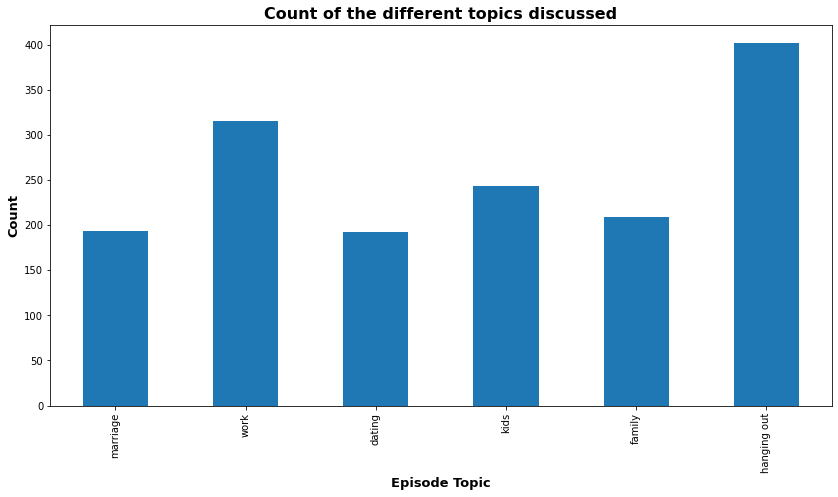

In [61]:
plt.figure(figsize=(14, 7))
topic_df.loc[:, 'marriage':'hanging out'].sum().plot.bar()
plt.xlabel('Episode Topic', size='13', weight='bold')
plt.ylabel('Count', size='13', weight='bold')
plt.title('Count of the different topics discussed', size='16', weight='bold')

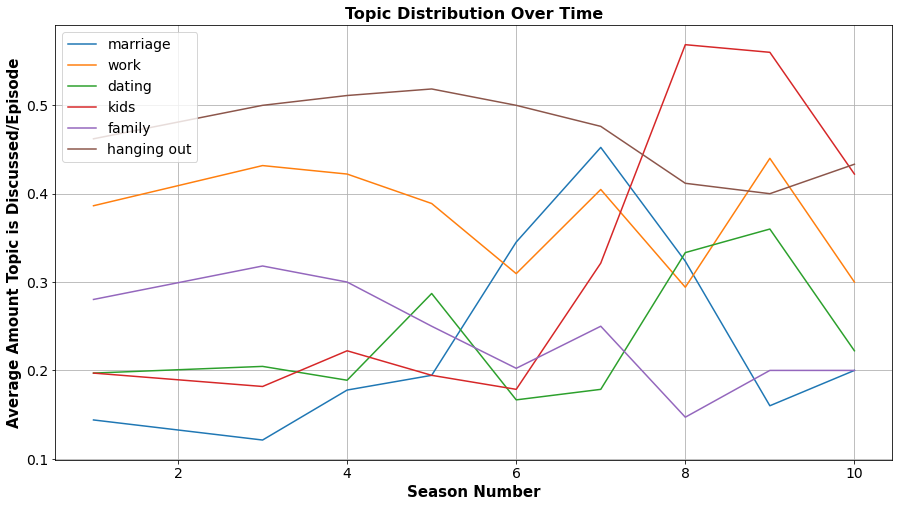

In [62]:
topics = ['marriage', 'work', 'dating', 'kids', 'family', 'hanging out']
topic_list_df = []
plt.figure(figsize=(15,8))
for topic in topics: 
    topic_df.groupby('season_number')[topic].mean().plot(label = topic)
    topic_list_df.append(topic_df.groupby('season_number')[topic].mean())
plt.legend(fontsize=14, loc='best')
plt.xlabel('Season Number', size='15', weight='bold')
plt.ylabel('Average Amount Topic is Discussed/Episode', size='15', weight='bold')
plt.xticks(size='14')
plt.yticks(size='14')

plt.title('Topic Distribution Over Time', size='16', weight='bold')
plt.grid()
topic_list_df = pd.concat(topic_list_df, axis=1)


In [63]:

topic_list_df.reset_index()

,season_number,marriage,work,dating,kids,family,hanging out
0,1,0.143940,0.386364,0.196970,0.196970,0.280303,0.462121
1,3,0.121213,0.431818,0.204546,0.181819,0.318182,0.500000
2,4,0.177778,0.422222,0.188890,0.222223,0.300000,0.511114
3,5,0.194445,0.388889,0.287037,0.194445,0.250001,0.518518
4,6,0.345238,0.309524,0.166667,0.178572,0.202382,0.500000
5,7,0.452381,0.404762,0.178572,0.321429,0.250000,0.476191
6,8,0.323530,0.294118,0.333334,0.568627,0.147060,0.411765
7,9,0.160001,0.440000,0.360000,0.560000,0.200001,0.400000
8,10,0.200001,0.300000,0.222223,0.422222,0.200001,0.433333


In [64]:
topic_list_df.to_csv('topic_list_df.csv')